# Restaurant Recommendation Challenge

The objective of this competition is to build a recommendation engine to predict what restaurants customers are most likely to order from given the customer location, restaurant information, and the customer order history.

The error metric for this competition is the F1 score, which ranges from 0 (total failure) to 1 (perfect score). Hence, the closer your score is to 1, the better your model.

[https://www.kaggle.com/mrmorj/restaurant-recommendation-challenge](https://www.kaggle.com/mrmorj/restaurant-recommendation-challenge)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from numpy import log

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
vendors = pd.read_csv('vendors.csv')
train_orders = pd.read_csv('orders.csv')
train_customers = pd.read_csv('train_customers.csv')
train_locations = pd.read_csv('train_locations.csv')

C:\Users\alexp\anaconda3\envs\deep\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (15,16,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Exploration

## Orders

In [3]:
train_orders.head(5)

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,vendor_rating,driver_rating,deliverydistance,preparationtime,delivery_time,order_accepted_time,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
0,163238.0,92PEE24,1.0,7.6,2,NaN,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,105,2019-08-01 05:30:16,0,NaN,92PEE24 X 0 X 105
1,163240.0,QS68UD8,1.0,8.7,1,NaN,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,294,2019-08-01 05:31:10,0,Work,QS68UD8 X 0 X 294
2,163241.0,MB7VY5F,2.0,14.4,1,NaN,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:31:33,0,NaN,MB7VY5F X 0 X 83
3,163244.0,KDJ951Y,1.0,7.1,1,NaN,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,2019-08-01 04:03:00,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,90,2019-08-01 05:34:54,0,Home,KDJ951Y X 0 X 90
4,163245.0,BAL0RVT,4.0,27.2,1,NaN,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:35:51,0,Work,BAL0RVT X 0 X 83


In [4]:
train_orders.dtypes

akeed_order_id                    float64
customer_id                        object
item_count                        float64
grand_total                       float64
payment_mode                        int64
promo_code                         object
vendor_discount_amount            float64
promo_code_discount_percentage    float64
is_favorite                        object
is_rated                           object
vendor_rating                     float64
driver_rating                     float64
deliverydistance                  float64
preparationtime                   float64
delivery_time                      object
order_accepted_time                object
driver_accepted_time               object
ready_for_pickup_time              object
picked_up_time                     object
delivered_time                     object
delivery_date                      object
vendor_id                           int64
created_at                         object
LOCATION_NUMBER                   

In [5]:
train_orders.describe()

,akeed_order_id,item_count,grand_total,payment_mode,vendor_discount_amount,promo_code_discount_percentage,vendor_rating,driver_rating,deliverydistance,preparationtime,vendor_id,LOCATION_NUMBER
count,135233.000000,128378.000000,135303.000000,135303.000000,135303.000000,65880.000000,45220.000000,135303.000000,135303.000000,79743.000000,135303.000000,135303.000000
mean,265190.206155,2.405404,15.374513,1.345159,0.001053,0.026639,1.959730,0.675366,4.104255,43.181721,239.214866,0.867527
std,85051.488939,1.645332,12.556177,0.763712,0.047331,0.813320,2.313294,1.667261,4.361884,7.107582,226.437406,1.239884
min,11044.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,4.000000,0.000000
25%,190852.000000,1.000000,8.200000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,84.000000,0.000000
50%,267166.000000,2.000000,11.700000,1.000000,0.000000,0.000000,0.000000,0.000000,2.900000,45.000000,157.000000,0.000000
75%,336230.000000,3.000000,18.500000,1.000000,0.000000,0.000000,5.000000,0.000000,7.920000,45.000000,299.000000,1.000000
max,415515.000000,68.000000,783.800000,5.000000,10.650000,25.000000,5.000000,5.000000,19.810000,90.000000,907.000000,25.000000


<AxesSubplot:>

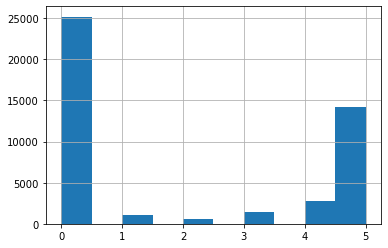

In [6]:
train_orders['vendor_rating'].hist()

<AxesSubplot:>

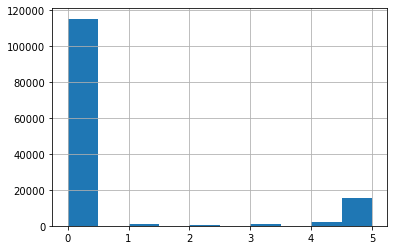

In [7]:
train_orders['driver_rating'].hist()

In [8]:
train_orders['is_favorite'].value_counts()

No     98449
Yes     1659
Name: is_favorite, dtype: int64

In [9]:
train_orders['is_rated'].value_counts()

No     115194
Yes     20109
Name: is_rated, dtype: int64

<AxesSubplot:>

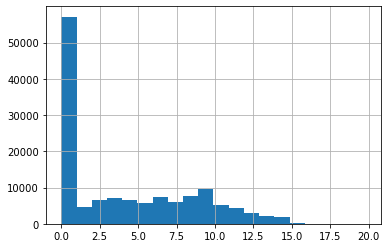

In [10]:
train_orders['deliverydistance'].hist(bins=20)

In [11]:
train_orders['delivery_date'].isnull().value_counts()

True     99759
False    35544
Name: delivery_date, dtype: int64

In [12]:
train_orders['created_at'].isnull().value_counts()

False    135303
Name: created_at, dtype: int64

Notes:

- 135,233 orders
- grand_total can be 0
- vendor_discount_amount and promo_discount_percentage are mostly 0
- vendor and driver ratings are mostly either 0 or 5
- deliverydistance can be 0(?) and is at most ~20
- delivery_date can be null but created_at is similar and never null


# Customers

In [13]:
train_customers.head(5)

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
0,TCHWPBT,Male,NaN,1,1,EN,2018-02-07 19:16:23,2018-02-07 19:16:23
1,ZGFSYCZ,Male,NaN,1,1,EN,2018-02-09 12:04:42,2018-02-09 12:04:41
2,S2ALZFL,Male,NaN,0,1,EN,2018-03-14 18:31:43,2018-03-14 18:31:42
3,952DBJQ,Male,NaN,1,1,EN,2018-03-15 19:47:07,2018-03-15 19:47:07
4,1IX6FXS,Male,NaN,1,1,EN,2018-03-15 19:57:01,2018-03-15 19:57:01


In [14]:
train_customers.dtypes

akeed_customer_id     object
gender                object
dob                  float64
status                 int64
verified               int64
language              object
created_at            object
updated_at            object
dtype: object

In [15]:
# Add num_locations as new column in customer table

locations_customer_grp = train_locations.groupby(by=['customer_id'])
locations_per_customer = locations_customer_grp['location_number'].count().rename('num_locations')
train_customers = train_customers.merge(locations_per_customer, how='left', left_on='akeed_customer_id', right_index=True)

In [15]:
train_customers.describe()

,dob,status,verified
count,3046.000000,34674.000000,34674.000000
mean,1991.210768,0.998991,0.956538
std,48.422045,0.031756,0.203898
min,1.000000,0.000000,0.000000
25%,1986.000000,1.000000,1.000000
50%,1993.000000,1.000000,1.000000
75%,1999.000000,1.000000,1.000000
max,2562.000000,1.000000,1.000000


In [16]:
train_customers['gender'].value_counts()

Male          17815
male           2914
Female         1761
Female           13
Male              9
?????             2
Female            2
Female            2
                  1
Female            1
Name: gender, dtype: int64

In [17]:
# clean gender column and remove outliers
train_customers['gender'] = train_customers['gender'].str.strip()
train_customers['gender'] = train_customers['gender'].str.lower()
gender_filter = (train_customers['gender'] == 'male') | (train_customers['gender'] == 'female')
train_customers = train_customers[gender_filter]
train_customers['gender'].value_counts()

male      20738
female     1779
Name: gender, dtype: int64

In [18]:
train_customers['language'].value_counts()

EN    16576
Name: language, dtype: int64

In [19]:
ser = train_customers['created_at'] == train_customers['updated_at']
ser.value_counts()

False    15898
True      6619
dtype: int64

In [20]:
train_customers[train_customers['num_locations'] > 20]

KeyError: 'num_locations'

Notes:

- 34,674 customers

- Most customers have only 1 location

- Gender column has repeated values?

- Outliers in num_locations

- Constant columns: language

# Vendors

We should prioritize cleaning this table because it will likely be the most useful data for our model. 

In [21]:
vendors.head(5)

,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,OpeningTime2,prepration_time,commission,is_akeed_delivering,discount_percentage,status,verified,rank,language,vendor_rating,sunday_from_time1,sunday_to_time1,sunday_from_time2,sunday_to_time2,monday_from_time1,monday_to_time1,monday_from_time2,monday_to_time2,tuesday_from_time1,tuesday_to_time1,tuesday_from_time2,tuesday_to_time2,wednesday_from_time1,wednesday_to_time1,wednesday_from_time2,wednesday_to_time2,thursday_from_time1,thursday_to_time1,thursday_from_time2,thursday_to_time2,friday_from_time1,friday_to_time1,friday_from_time2,friday_to_time2,saturday_from_time1,saturday_to_time1,saturday_from_time2,saturday_to_time2,primary_tags,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
0,4,118597.0,-0.588596,0.754434,Restaurants,2.0,0.0,6.0,1.0,11:00AM-11:30PM,-,15,0.0,Yes,0.0,1.0,1,11,EN,4.4,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,10:00:00,23:59:00,00:00:00,00:30:00,10:00:00,23:59:00,"{""primary_tags"":""4""}",1.0,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1
1,13,118608.0,-0.471654,0.744470,Restaurants,2.0,0.7,5.0,1.0,08:30AM-10:30PM,-,14,0.0,Yes,0.0,1.0,1,11,EN,4.7,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,19:30:00,00:00:00,01:30:00,08:00:00,19:30:00,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,23:59:00,"{""primary_tags"":""7""}",1.0,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1
2,20,118616.0,-0.407527,0.643681,Restaurants,2.0,0.0,8.0,1.0,08:00AM-10:45PM,-,19,0.0,Yes,0.0,1.0,1,1,EN,4.5,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,"{""primary_tags"":""71""}",1.0,"4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",Y,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1
3,23,118619.0,-0.585385,0.753811,Restaurants,2.0,0.0,5.0,1.0,10:59AM-10:30PM,-,16,0.0,Yes,0.0,1.0,1,11,EN,4.5,09:00:00,23:30:00,NaN,NaN,09:00:00,23:30:00,NaN,NaN,09:00:00,23:30:00,NaN,NaN,09:00:00,23:30:00,NaN,NaN,09:00:00,23:45:00,NaN,NaN,09:00:00,23:45:00,NaN,NaN,09:00:00,23:45:00,NaN,NaN,"{""primary_tags"":""46""}",1.0,"5,8,30,24","Burgers,Desserts,Fries,Salads",Y,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3,1
4,28,118624.0,0.480602,0.552850,Restaurants,2.0,0.7,15.0,1.0,11:00AM-11:45PM,-,10,0.0,Yes,0.0,1.0,1,11,EN,4.4,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,01:30:00,17:45:00,23:59:00,00:01:00,01:30:00,17:45:00,23:59:00,"{""primary_tags"":""32""}",1.0,5,Burgers,Y,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3,1


In [22]:
vendors.dtypes

id                        int64
authentication_id       float64
latitude                float64
longitude               float64
vendor_category_en       object
vendor_category_id      float64
delivery_charge         float64
serving_distance        float64
is_open                 float64
OpeningTime              object
OpeningTime2             object
prepration_time           int64
commission              float64
is_akeed_delivering      object
discount_percentage     float64
status                  float64
verified                  int64
rank                      int64
language                 object
vendor_rating           float64
sunday_from_time1        object
sunday_to_time1          object
sunday_from_time2        object
sunday_to_time2          object
monday_from_time1        object
monday_to_time1          object
monday_from_time2        object
monday_to_time2          object
tuesday_from_time1       object
tuesday_to_time1         object
tuesday_from_time2       object
tuesday_

In [35]:
vendors.isnull().sum()

id                       0
authentication_id        0
latitude                 0
longitude                0
vendor_category_en       0
vendor_category_id       0
delivery_charge          0
serving_distance         0
is_open                  0
OpeningTime              9
OpeningTime2             9
prepration_time          0
commission              15
is_akeed_delivering      0
discount_percentage      0
status                   0
verified                 0
rank                     0
language                15
vendor_rating            0
sunday_from_time1        1
sunday_to_time1          1
sunday_from_time2       58
sunday_to_time2         58
monday_from_time1        0
monday_to_time1          0
monday_from_time2       58
monday_to_time2         58
tuesday_from_time1       1
tuesday_to_time1         1
tuesday_from_time2      59
tuesday_to_time2        59
wednesday_from_time1     0
wednesday_to_time1       0
wednesday_from_time2    58
wednesday_to_time2      58
thursday_from_time1      1
t

Notes:
- 100 resturaunts
- Outliers present in `latitude`, `longitude`, `preparation_time`, `discount_percentage`
- Constant columns: `commission`, `open_close_flags`, `country_id`, `city_id`, `display_orders`, `one_click_vendor`, `is_akeed_delivering`, `language`
- Nearly constant: `discount_percentage`
- Columns (`status`, `verified`), (`vendor_category_en`, `vendor_category_id`) are almost equal 
- Median and Max `serving_distance` is 15
- `rank` is either 1 or 11...?
- `vendor_rating` has small variance
- `vendor_tag` and `vendor_tag_name` are the same: lists of food types
- Columns recording open/close times are confusing...

In [24]:
vendors['vendor_category_en'].value_counts()

Restaurants       88
Sweets & Bakes    12
Name: vendor_category_en, dtype: int64

In [25]:
vendors['vendor_category_id'].value_counts()

2.0    89
3.0    11
Name: vendor_category_id, dtype: int64

In [26]:
vendors['is_akeed_delivering'].value_counts()

Yes    100
Name: is_akeed_delivering, dtype: int64

In [27]:
vendors['language'].value_counts()

EN    85
Name: language, dtype: int64

In [28]:
vendors['one_click_vendor'].value_counts()

Y    100
Name: one_click_vendor, dtype: int64

In [29]:
vendors['primary_tags'].value_counts()

{"primary_tags":"134"}     10
{"primary_tags":"2396"}     8
{"primary_tags":"8"}        5
{"primary_tags":"1088"}     3
{"primary_tags":"2072"}     3
{"primary_tags":"701"}      3
{"primary_tags":"46"}       3
{"primary_tags":"24"}       3
{"primary_tags":"32"}       3
{"primary_tags":"21"}       2
{"primary_tags":"90"}       2
{"primary_tags":"28"}       2
{"primary_tags":"1256"}     1
{"primary_tags":"270"}      1
{"primary_tags":"35"}       1
{"primary_tags":"346"}      1
{"primary_tags":"1348"}     1
{"primary_tags":"849"}      1
{"primary_tags":"695"}      1
{"primary_tags":"1065"}     1
{"primary_tags":"52"}       1
{"primary_tags":"204"}      1
{"primary_tags":"323"}      1
{"primary_tags":"47"}       1
{"primary_tags":"51"}       1
{"primary_tags":"71"}       1
{"primary_tags":"534"}      1
{"primary_tags":"138"}      1
{"primary_tags":"1147"}     1
{"primary_tags":"478"}      1
{"primary_tags":"7"}        1
{"primary_tags":"4"}        1
{"primary_tags":"271"}      1
{"primary_

In [30]:
# Fill na with -1
# Strip unnecessary characters
vendors['primary_tags'] = vendors['primary_tags'].fillna("{\"primary_tags\":\"-1\"}").apply(lambda x: int(str(x).split("\"")[3]))
vendors['primary_tags'].value_counts().head(5)

0       23
134     10
2396     8
8        5
24       3
Name: primary_tags, dtype: int64

In [31]:
# Fill na with -1
# Turn vendor_tag into list-valued
vendors['vendor_tag'] = vendors['vendor_tag'].fillna(str(-1)).apply(lambda x: x.split(",")).apply(lambda x: [int(i) for i in x])
vendors['vendor_tag'].head(10)

0    [2, 4, 5, 8, 91, 22, 12, 24, 16, 23]
1     [4, 41, 51, 34, 27, 15, 24, 16, 28]
2                          [4, 8, 91, 10]
3                          [5, 8, 30, 24]
4                                     [5]
5                                 [8, 42]
6                          [1, 5, 30, 16]
7                          [1, 5, 30, 16]
8              [4, 8, 22, 32, 24, 16, 28]
9                       [4, 5, 8, 10, 24]
Name: vendor_tag, dtype: object

In [32]:
# Get unique vendor tags
# Map values to range(len(vendor_tags))
vendor_tags = [int(i) for i in vendors['vendor_tag'].explode().unique()]
vendor_tags.sort()
vendor_map = dict()
for i, tag in enumerate(vendor_tags):
    vendor_map[tag] = i
vendors['vendor_tag'] = vendors['vendor_tag'].apply(lambda tags: [vendor_map[tag] for tag in tags])
vendors['vendor_tag'].head(10)

0    [2, 4, 5, 8, 67, 19, 12, 21, 15, 20]
1     [4, 35, 45, 31, 24, 14, 21, 15, 25]
2                          [4, 8, 67, 10]
3                          [5, 8, 27, 21]
4                                     [5]
5                                 [8, 36]
6                          [1, 5, 27, 15]
7                          [1, 5, 27, 15]
8              [4, 8, 19, 29, 21, 15, 25]
9                       [4, 5, 8, 10, 21]
Name: vendor_tag, dtype: object

In [ ]:
# Add num_orders, amt_sales, and avg_sale as new columns in vendor table

orders_vendor_grp = train_orders.groupby(by=['vendor_id'])
orders_per_vendor = orders_vendor_grp['akeed_order_id'].count().rename('num_orders')
grand_total_per_vendor = orders_vendor_grp['grand_total'].sum().rename('amt_sales')

vendors = vendors.merge(orders_per_vendor, how='left', left_on='id', right_index=True)
vendors = vendors.merge(grand_total_per_vendor, how='left', left_on='id', right_index=True)
vendors['avg_sale'] = vendors['amt_sales'] / vendors['num_orders']

In [26]:
vendors.describe()

,id,authentication_id,latitude,longitude,vendor_category_id,delivery_charge,serving_distance,is_open,prepration_time,commission,discount_percentage,status,verified,rank,vendor_rating,open_close_flags,country_id,city_id,device_type,display_orders,num_orders,amt_sales,avg_sale
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.00000,85.0,100.000000,100.00000,100.000000,100.00000,100.000000,100.0,100.0,100.0,100.00,100.0,100.000000,100.00000,100.000000
mean,288.840000,120050.760000,1.875505,0.803682,2.110000,0.413000,11.750000,0.85000,14.03000,0.0,1.100000,0.85000,0.880000,9.90000,4.350000,1.0,1.0,1.0,2.98,1.0,1352.330000,20802.17700,15.802967
std,242.299994,3509.069064,20.600857,4.397859,0.314466,0.346018,4.108073,0.35887,4.31688,0.0,6.299751,0.35887,0.326599,3.14466,0.248836,0.0,0.0,0.0,0.20,0.0,1177.959973,17963.48658,5.858955
min,4.000000,118597.000000,-1.787413,-1.449556,2.000000,0.000000,2.000000,0.00000,5.00000,0.0,0.000000,0.00000,0.000000,1.00000,3.200000,1.0,1.0,1.0,1.00,1.0,474.000000,3638.00000,5.954173
25%,105.750000,118702.750000,-0.809124,0.081618,2.000000,0.000000,8.000000,1.00000,10.00000,0.0,0.000000,1.00000,1.000000,11.00000,4.200000,1.0,1.0,1.0,3.00,1.0,730.500000,10478.87500,12.086348
50%,202.000000,118801.000000,-0.493421,0.527123,2.000000,0.700000,15.000000,1.00000,15.00000,0.0,0.000000,1.00000,1.000000,11.00000,4.400000,1.0,1.0,1.0,3.00,1.0,941.000000,14878.05000,13.752940
75%,387.250000,118990.250000,0.015915,0.644764,2.000000,0.700000,15.000000,1.00000,15.00000,0.0,0.000000,1.00000,1.000000,11.00000,4.500000,1.0,1.0,1.0,3.00,1.0,1529.500000,22006.22500,17.854884
max,907.000000,132953.000000,205.242327,44.210807,3.000000,0.700000,15.000000,1.00000,45.00000,0.0,50.000000,1.00000,1.000000,11.00000,4.800000,1.0,1.0,1.0,3.00,1.0,7807.000000,114366.10000,34.310740


<AxesSubplot:>

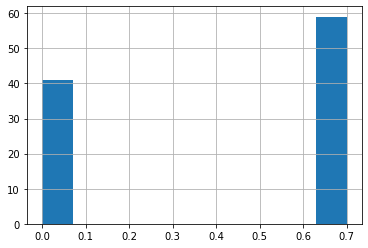

In [48]:
vendors['delivery_charge'].hist()

<AxesSubplot:>

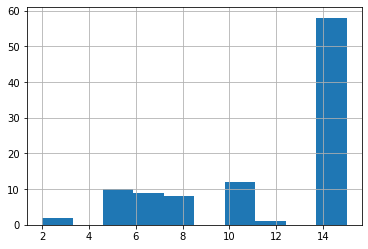

In [47]:
vendors['serving_distance'].hist()

<AxesSubplot:>

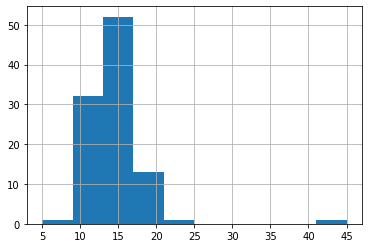

In [45]:
vendors['prepration_time'].hist()

<AxesSubplot:>

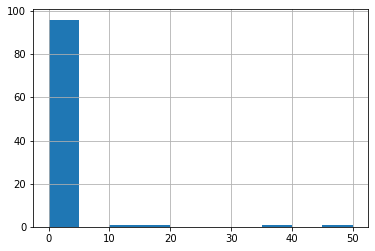

In [27]:
vendors['discount_percentage'].hist()

In [86]:
vendors['status'].value_counts()

1.0    85
0.0    15
Name: status, dtype: int64

In [85]:
vendors['verified'].value_counts()

1    88
0    12
Name: verified, dtype: int64

In [84]:
vendors['status_and_verified'] = vendors['status'] * vendors['verified']
vendors['status_and_verified'].value_counts()

1.0    85
0.0    15
Name: status_and_verified, dtype: int64

In [83]:
vendors['rank'].value_counts()

11    89
1     11
Name: rank, dtype: int64

<AxesSubplot:>

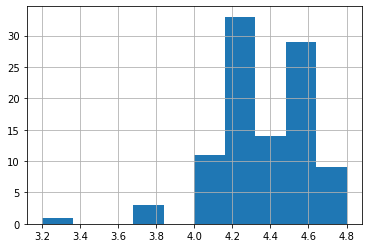

In [30]:
vendors['vendor_rating'].hist()

In [32]:
vendors[vendors.device_type == 1]

,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,OpeningTime2,prepration_time,commission,is_akeed_delivering,discount_percentage,status,verified,rank,language,vendor_rating,sunday_from_time1,sunday_to_time1,sunday_from_time2,sunday_to_time2,monday_from_time1,monday_to_time1,monday_from_time2,monday_to_time2,tuesday_from_time1,tuesday_to_time1,tuesday_from_time2,tuesday_to_time2,wednesday_from_time1,wednesday_to_time1,wednesday_from_time2,wednesday_to_time2,thursday_from_time1,thursday_to_time1,thursday_from_time2,thursday_to_time2,friday_from_time1,friday_to_time1,friday_from_time2,friday_to_time2,saturday_from_time1,saturday_to_time1,saturday_from_time2,saturday_to_time2,primary_tags,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders,num_orders,amt_sales,avg_sale
55,231,118830.0,205.242327,44.210807,Sweets & Bakes,3.0,0.7,10.0,1.0,9am-10pm,10pm-11pm,15,0.0,Yes,0.0,1.0,1,11,EN,4.3,NaN,NaN,NaN,NaN,09:00:00,21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,10:00:00,16:01:00,17:00:00,23:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Y,1.0,1.0,2019-04-24 20:04:18,2020-03-20 09:45:15,1,1,810,7719.2,9.529877


<AxesSubplot:>

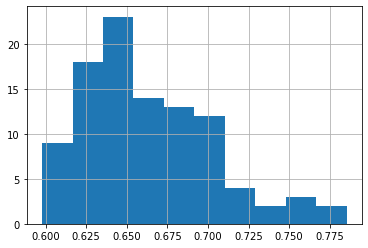

In [68]:
vendors['num_orders_log3'] = vendors['num_orders'].apply(log).apply(log).apply(log)
vendors['num_orders_log3'].hist()

<AxesSubplot:>

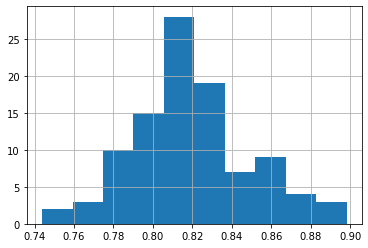

In [69]:
vendors['amt_sales_log3'] = vendors['amt_sales'].apply(log).apply(log).apply(log)
vendors['amt_sales_log3'].hist()

<AxesSubplot:>

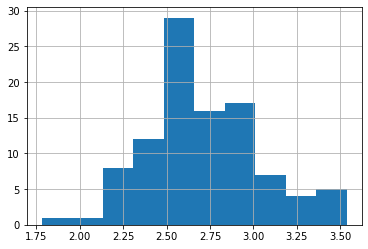

In [70]:
vendors['avg_sale_log'] = vendors['avg_sale'].apply(log)
vendors['avg_sale_log'].hist()

In [23]:
keep_continuous = ['latitude', 'longituide', 'delivery_charge', 'serving_distance', 'preparation_time', 'vendor_rating', 'num_orders_log3', 'amt_sales_log3', 'avg_sale_log']
keep_categorical = ['vendor_category_id', 'status_and_verified', 'rank', 'primary_tags', 'vendor_tag']
keep_columns = keep_continuous + keep_categorical

# Locations

In [17]:
# Examine the location outliers

vendors[vendors['latitude'] > 3]

,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,OpeningTime2,prepration_time,commission,is_akeed_delivering,discount_percentage,status,verified,rank,language,vendor_rating,sunday_from_time1,sunday_to_time1,sunday_from_time2,sunday_to_time2,monday_from_time1,monday_to_time1,monday_from_time2,monday_to_time2,tuesday_from_time1,tuesday_to_time1,tuesday_from_time2,tuesday_to_time2,wednesday_from_time1,wednesday_to_time1,wednesday_from_time2,wednesday_to_time2,thursday_from_time1,thursday_to_time1,thursday_from_time2,thursday_to_time2,friday_from_time1,friday_to_time1,friday_from_time2,friday_to_time2,saturday_from_time1,saturday_to_time1,saturday_from_time2,saturday_to_time2,primary_tags,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders,num_orders,amt_sales,avg_sale
55,231,118830.0,205.242327,44.210807,Sweets & Bakes,3.0,0.7,10.0,1.0,9am-10pm,10pm-11pm,15,0.0,Yes,0.0,1.0,1,11,EN,4.3,NaN,NaN,NaN,NaN,09:00:00,21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,10:00:00,16:01:00,17:00:00,23:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Y,1.0,1.0,2019-04-24 20:04:18,2020-03-20 09:45:15,1,1,810,7719.2,9.529877
99,907,132953.0,13.335131,-1.449556,Restaurants,2.0,0.7,12.0,1.0,NaN,NaN,20,NaN,Yes,0.0,1.0,1,11,NaN,4.3,11:00:00,12:30:00,16:30:00,23:15:00,11:00:00,12:30:00,16:30:00,23:15:00,11:00:00,12:30:00,16:30:00,23:15:00,11:00:00,12:30:00,16:30:00,23:15:00,11:00:00,12:30:00,16:30:00,23:15:00,NaN,NaN,16:30:00,23:15:00,11:00:00,12:30:00,16:30:00,23:15:00,"{""primary_tags"":""24""}",1.0,"46,52,16","Fatayers,Mojitos ,Sandwiches",Y,1.0,1.0,2020-01-05 18:56:58,2020-04-06 23:49:52,3,1,611,3638.0,5.954173


In [18]:
vendors[vendors['longitude'] > 3]

,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,OpeningTime2,prepration_time,commission,is_akeed_delivering,discount_percentage,status,verified,rank,language,vendor_rating,sunday_from_time1,sunday_to_time1,sunday_from_time2,sunday_to_time2,monday_from_time1,monday_to_time1,monday_from_time2,monday_to_time2,tuesday_from_time1,tuesday_to_time1,tuesday_from_time2,tuesday_to_time2,wednesday_from_time1,wednesday_to_time1,wednesday_from_time2,wednesday_to_time2,thursday_from_time1,thursday_to_time1,thursday_from_time2,thursday_to_time2,friday_from_time1,friday_to_time1,friday_from_time2,friday_to_time2,saturday_from_time1,saturday_to_time1,saturday_from_time2,saturday_to_time2,primary_tags,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders,num_orders,amt_sales,avg_sale
55,231,118830.0,205.242327,44.210807,Sweets & Bakes,3.0,0.7,10.0,1.0,9am-10pm,10pm-11pm,15,0.0,Yes,0.0,1.0,1,11,EN,4.3,NaN,NaN,NaN,NaN,09:00:00,21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,10:00:00,16:01:00,17:00:00,23:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Y,1.0,1.0,2019-04-24 20:04:18,2020-03-20 09:45:15,1,1,810,7719.2,9.529877


In [19]:
orders_231 = train_orders[train_orders['vendor_id'] == 231]
orders_907 = train_orders[train_orders['vendor_id'] == 907]

orders_231 = orders_231.merge(train_locations, how='left', left_on=['customer_id', 'LOCATION_NUMBER'], right_on=['customer_id', 'location_number'])
orders_907 = orders_907.merge(train_locations, how='left', left_on=['customer_id', 'LOCATION_NUMBER'], right_on=['customer_id', 'location_number'])

In [20]:
lat231 = vendors[vendors['id'] == 231].latitude.item()
long231 = vendors[vendors['id'] == 231].longitude.item()
lat907 = vendors[vendors['id'] == 907].latitude.item()
long907 = vendors[vendors['id'] == 907].longitude.item()

print(f'231 actual: \tLat = {lat231:.3f}, Long = {long231:.3f}')
print(f'231 estimate: \tLat = {orders_231.latitude.median():.3f}, Long = {orders_231.longitude.median():.3f}')
print(f'907 actual: \tLat = {lat907:.3f}, Long = {long907:.3f}')
print(f'907 estimate: \tLat = {orders_907.latitude.median():.3f}, Long = {orders_907.longitude.median():.3f}')

231 actual: 	Lat = 205.242, Long = 44.211
231 estimate: 	Lat = -0.127, Long = -78.525
907 actual: 	Lat = 13.335, Long = -1.450
907 estimate: 	Lat = 13.309, Long = -1.396


In [21]:
orders_907.describe()

,akeed_order_id,item_count,grand_total,payment_mode,vendor_discount_amount,promo_code_discount_percentage,vendor_rating,driver_rating,deliverydistance,preparationtime,vendor_id,LOCATION_NUMBER,location_number,latitude,longitude
count,611.000000,614.000000,614.000000,614.000000,614.0,614.0,141.000000,614.000000,614.000000,614.000000,614.0,614.000000,614.000000,614.000000,614.000000
mean,379618.612111,2.708469,5.925081,1.073290,0.0,0.0,4.460993,0.957655,6.158127,49.771987,907.0,0.151466,0.151466,13.363299,-1.408124
std,22425.630322,1.436427,4.380349,0.419162,0.0,0.0,1.137150,1.866201,2.245379,3.888343,0.0,0.509155,0.509155,0.547105,0.045653
min,335546.000000,1.000000,0.500000,1.000000,0.0,0.0,1.000000,0.000000,0.080000,40.000000,907.0,0.000000,0.000000,11.644491,-1.607014
25%,361307.000000,2.000000,3.000000,1.000000,0.0,0.0,5.000000,0.000000,5.135000,50.000000,907.0,0.000000,0.000000,13.127550,-1.451364
50%,381438.000000,2.000000,4.600000,1.000000,0.0,0.0,5.000000,0.000000,6.330000,50.000000,907.0,0.000000,0.000000,13.308979,-1.395678
75%,399160.000000,3.000000,7.300000,1.000000,0.0,0.0,5.000000,0.000000,6.925000,50.000000,907.0,0.000000,0.000000,13.449262,-1.383202
max,415450.000000,9.000000,30.200000,4.000000,0.0,0.0,5.000000,5.000000,14.940000,65.000000,907.0,4.000000,4.000000,15.273853,-1.277366


In [31]:
train_locations.head(5)

,customer_id,location_number,location_type,latitude,longitude
0,02SFNJH,0,NaN,1.682392,-78.789737
1,02SFNJH,1,NaN,1.679137,0.766823
2,02SFNJH,2,NaN,-0.498648,0.661241
3,RU43CXC,0,Home,0.100853,0.438165
4,BDFBPRD,0,NaN,2.523125,0.733464


In [32]:
train_locations.dtypes

customer_id         object
location_number      int64
location_type       object
latitude           float64
longitude          float64
dtype: object

In [33]:
# Aggregate # orders, $ sales, and avg spent by customer location
# (customers can have multiple locations registered to themselves)

orders_location_grp = train_orders.groupby(['customer_id', 'LOCATION_NUMBER'])
orders_per_location = orders_location_grp['akeed_order_id'].count().rename('num_orders')    # multi index: [customer_id, LOCATION_NUMBER]
sales_per_location = orders_location_grp['grand_total'].sum().rename('amt_spent')           # multi index: [customer_id, LOCATION_NUMBER]

train_locations = train_locations.merge(sales_per_location, how='left', left_on=['customer_id', 'location_number'], right_index=True)
train_locations = train_locations.merge(orders_per_location, how='left', left_on=['customer_id', 'location_number'], right_index=True)
train_locations['avg_spend'] = train_locations['amt_spent'] / train_locations['num_orders']


In [34]:
train_locations.describe()

,location_number,latitude,longitude,amt_spent,num_orders,avg_spend
count,59503.000000,59497.000000,59497.000000,43641.000000,43641.000000,4.363800e+04
mean,0.753592,2.361135,-25.115410,47.666591,3.098760,inf
std,1.355645,22.734109,36.946014,77.897039,4.347092,NaN
min,0.000000,-1038.149292,-134.415302,0.000000,0.000000,0.000000e+00
25%,0.000000,-0.502593,-78.522567,12.000000,1.000000,8.725000e+00
50%,0.000000,-0.087860,0.021342,23.400000,2.000000,1.265000e+01
75%,1.000000,0.261727,0.514671,51.400000,3.000000,1.897964e+01
max,29.000000,453.653846,45.354231,2504.600000,125.000000,inf


**Note from VariableDefinitions.txt:** 

"Not true latitude and longitude - locations have been masked, but nearby locations remain nearby in the new reference frame and can thus be used for clustering. However, not all locations are useful due to GPS errors and missing data - you may want to treat outliers separately."

This will make our life difficult because we have no way of knowing how the location data has been transformed, thus it's not really clear how we should define "outlier".

Almost all vendors are clustered very close to each other, but we will soon see that about 1/3rd of customer locations are "far" from this cluster.


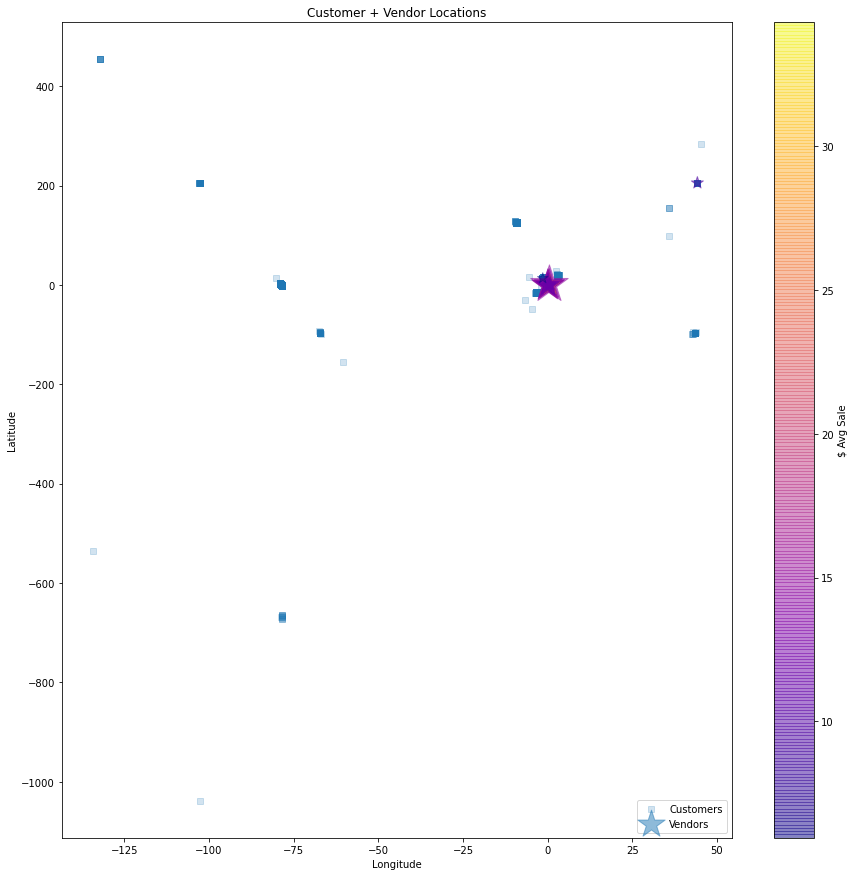

In [35]:
# Map out customer locations and vendor locations

plt.figure(figsize=(15, 15))
plt.scatter(x=train_locations.longitude, y=train_locations.latitude, label='Customers', marker='s', alpha=0.2)
plt.scatter(x=vendors.longitude, y=vendors.latitude, label='Vendors', marker='*', alpha=0.5, s=vendors['num_orders']/5, c=vendors['avg_sale'], cmap='plasma')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='lower right')
plt.colorbar(label='$ Avg Sale')
plt.title('Customer + Vendor Locations')
plt.show()

# Stars:
#   Size: Unpopular <----------> Popular
#   Heat:     Cheap <----------> Expensive

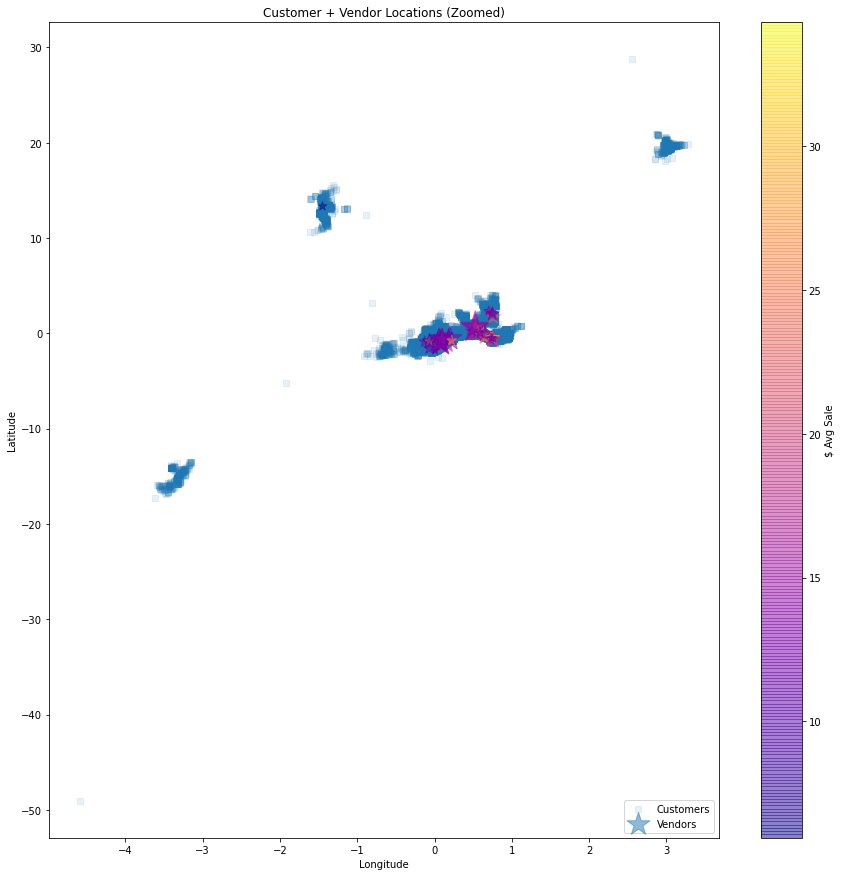

In [36]:
# Outliers in location are probably a mistake (GPS error?)
# Zoom in on area close with most activity
#     Marker Size = # Orders
#           Color = $ Grand Total

lo = -5
hi = 5

filt1 = (lo < train_locations['longitude']) & (train_locations['longitude'] < hi)
filt2 = (lo < vendors['longitude']) & (vendors['longitude'] < hi)
train_locations_cut = train_locations[filt1]
vendors_cut = vendors[filt2]

plt.figure(figsize=(15, 15))
plt.scatter(x=train_locations_cut.longitude, y=train_locations_cut.latitude, label='Customers', marker='s', alpha=0.1)
plt.scatter(x=vendors_cut.longitude, y=vendors_cut.latitude, label='Vendors', marker='*', alpha=0.5, s=vendors_cut['num_orders']/7, c=vendors_cut['avg_sale'], cmap='plasma')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='lower right')
plt.colorbar(label='$ Avg Sale')
plt.title('Customer + Vendor Locations (Zoomed)')
plt.show()

# Stars:
#   Size: Unpopular <----------> Popular
#   Heat:     Cheap <----------> Expensive


In [37]:
# Define outliers for customer locations
# There are a lot of customers that are outside the "vendor bubble"
#   vendor bubble == customers that aren't outliers

lat_lo, lat_hi = -25, 25
long_lo, long_hi = -5, 5
c_outliers = (train_locations['latitude'] < lat_lo) | (train_locations['latitude'] > lat_hi) | (train_locations['longitude'] < long_lo) | (train_locations['longitude'] > long_hi)
v_outliers = (vendors['latitude'] < lat_lo) | (vendors['latitude'] > lat_hi) | (vendors['longitude'] < long_lo) | (vendors['longitude'] > long_hi)


train_locations[c_outliers].describe()

,location_number,latitude,longitude,amt_spent,num_orders,avg_spend
count,20337.000000,20337.000000,20337.000000,14547.000000,14547.000000,14547.000000
mean,0.307125,6.261545,-74.061024,45.568248,2.711006,17.017880
std,0.853203,38.319197,18.784324,70.816958,3.551637,14.363682
min,0.000000,-1038.149292,-134.415302,0.000000,1.000000,0.000000
25%,0.000000,-0.480240,-78.609553,12.200000,1.000000,9.205000
50%,0.000000,-0.081776,-78.575659,23.300000,1.000000,13.600000
75%,0.000000,0.300072,-78.517420,49.450000,3.000000,20.400000
max,29.000000,453.653846,45.354231,1858.100000,123.000000,783.800000


100%|██████████| 1/1 [00:00<?, ?it/s]


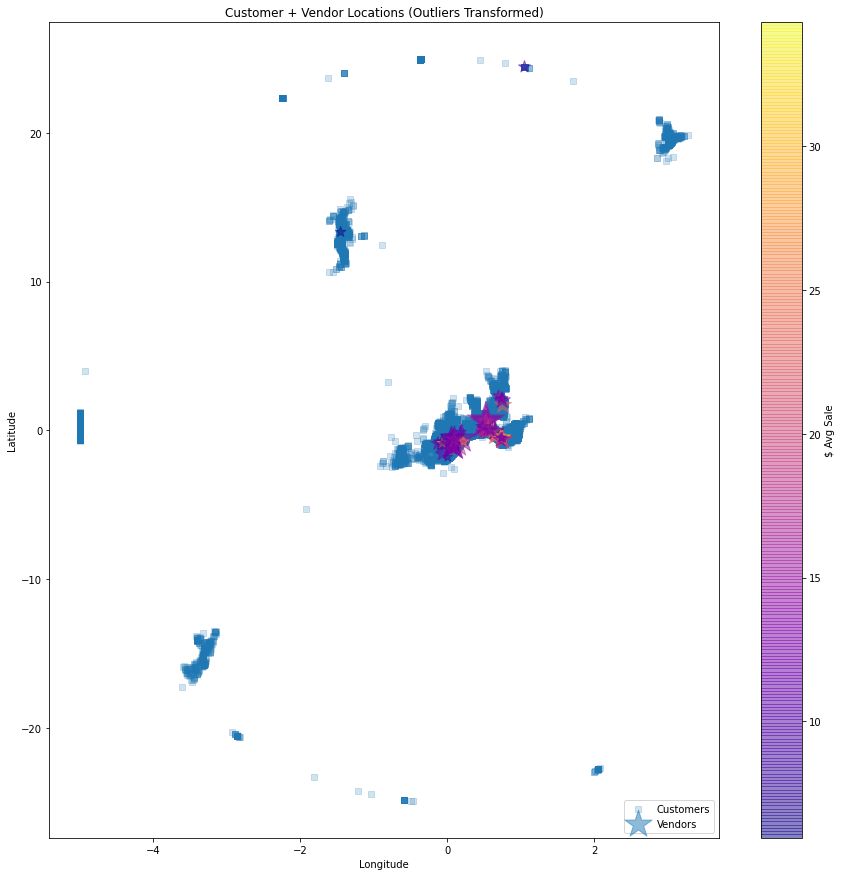

In [38]:
# Want to transform outliers so that they are closer to vendors, but also stay in their clusters
#   Project outliers onto ellipse around bubble

from math import sqrt

lat_radius = lat_hi
long_radius = long_hi

# Project customer outliers
for i in tqdm(train_locations[c_outliers].index):
        lat = train_locations.loc[i, 'latitude']
        long = train_locations.loc[i, 'longitude']
        mag = sqrt(lat**2 + long**2)
        train_locations.loc[i, 'latitude'] = lat / mag * lat_radius
        train_locations.loc[i, 'longitude'] = long / mag * long_radius

# Project vendor outliers
for i in tqdm(vendors[v_outliers].index):
        lat = vendors.loc[i, 'latitude']
        long = vendors.loc[i, 'longitude']
        mag = sqrt(lat**2 + long**2)
        vendors.loc[i, 'latitude'] = lat / mag * lat_radius
        vendors.loc[i, 'longitude'] = long / mag * long_radius

plt.figure(figsize=(15, 15))
plt.scatter(x=train_locations.longitude, y=train_locations.latitude, label='Customers', marker='s', alpha=0.2)
plt.scatter(x=vendors.longitude, y=vendors.latitude, label='Vendors', marker='*', alpha=0.5, s=vendors['num_orders']/5, c=vendors['avg_sale'], cmap='plasma')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='lower right')
plt.colorbar(label='$ Avg Sale')
plt.title('Customer + Vendor Locations (Outliers Transformed)')
plt.show()

# Collaborative Filtering (CF)

Collaborative filtering is a general technique to provide recommendations to one user based on all of the other users preferences. This contrasts with content-based recommender systems, where the recommendations are based on product content. There are a few different ways to perform CF, two of which we will define below.

## Customer-Based CF

Customer-Based CF will attempt to learn a similarity function on all pairs of users. A recommendation will be given to a customer based on how other similar customers behave. 

For example, if customer A and customer B both rate restaurant X highly, and customer A ranks restaurant Y highly, then the recommender system might recommend restaurant Y to customer B.

## Item-Based CF

Item-Based CF will attempt to learn a similarity function on all pairs of items. Similar items will be recommended to the user based on their item history.

For example, if restaurants X and Y are similar, and customer A has recently ordered from restaurant X, then the recommender system might recommend restaurant Y.

## Item Representation

Suppose we want to implement Item-Based CF. How can we define similarity between items mathematically? What we are looking for is an embedding 
$$W: \textrm{Items} \to \mathbb{R}^N$$
for some value of $N$ (consider this value as a hyperparameter) such that if items $X$ and $Y$ are similar, then $W(X)$ and $W(Y)$ are similar. Similarity for items is usually a matter of semantics, while similarity for vectors can be defined mathematically. If $N$ is large, it's more useful to use cosine similarity instead of Euclidean distance. Cosine similarity between vectors $\vec{x} = W(X)$ and $\vec{y} = W(Y)$ as 
$$d(\vec{x}, \vec{y}) = \frac{\vec{x} \cdot \vec{y}}{||\vec{x}|| \cdot ||\vec{y}||}.$$
This is simply equal to $\cos(\theta)$ where $\theta$ is the angle between the two vectors. 

There are many known ways to learn an embedding $W$ with this property. We will discuss one method here, called Skip-Gram, which originates from the field of natural language processing. Suppose we have some sequences of categorical items with the number of unique items present equal to $I$. With this structure, items may be considered to be similar if they commonly show up near each other in the sequences (**maybe we could do something more sophisticated here with other features**). 

Next, we will construct a simple (but possibly large in memory) neural network 
$$f = \big( \mathbb{R}^I \overset{W}{\longrightarrow} \mathbb{R}^N \overset{U}{\longrightarrow} \mathbb{R}^A \overset{\sigma}{\longrightarrow} \mathbb{R}^A \big)$$
where $W$ and $U$ are linear maps, $\sigma$ is softmax, and $N << A$. The inputs are items $X$ that have been one-hot encoded. Each dimension in the output represents an item $Y$, and the value in a given dimension is the probability that $Y$ is to be found "close to" $X$ in a sequence, where "close to" is a hyperparameter used to generate labels for the training data, as described above. Once the network is trained, the linear map $W$ provides an embedding of the set of items into a relatively low-dimensional vector space (hopefully $W$ is non-singular). Since the inputs are one-hot encoded, the rows of $W$ are the vector embeddings we are looking for. Therefore, we can find any item's representation by a simple lookup in $W$. 

## Use Item-Based CF For Learning Vendor Representation

We can consider each user (or user location) as a sequence of vendors. We can learn a vendor representation and hence some notion of vendor similarity by applying to Skip-Gram model to these sequences. 

First, we need to restructure our order data so that the orders are grouped by users (or user locations) and ordered chronologically. Next, we must choose a length for the sliding window that rolls through our sequences.

<p align="center">
  <img src="word2vec.jpg" />
</p>
https://www.geeksforgeeks.org/implement-your-own-word2vecskip-gram-model-in-python/

In [30]:
# Need to construct training data. 
# First construct sequences of orders from users or user locations 
#   Group orders by [customer_id, LOCATION_NUMBER] or [customer_id]
#   Sort each group chronologically, by created_at
#   Collect each group into a list of ints
# For each order X in the sequence, call another order Y "close enough" if it is within r orders in the sequence of X
# For each order X and for each order Y close enough to X, construct (train,test)=(x,y)
# One-hot encode vectors before we input to network.

# PROBLEM(?): Most sequences have length 1.... thus no windows for those 
#   Group orders by:    [customer_id, LOCATION_NUMBER] -> 50% length 1 sequences
#   Group orders by:                     [customer_id] -> 36% length 1 sequences

# Maybe it's not a big problem because there will be many more windows and pairs than length 1 sequences

train_orders['created_at'] = pd.to_datetime(train_orders['created_at'])
train_orders.sort_values(by=['created_at'], inplace=True)

orders_grp = train_orders.groupby(by=['customer_id', 'LOCATION_NUMBER'])
orders_grp['vendor_id'].count().value_counts(normalize=True).head(5)

1    0.490227
2    0.179464
3    0.090672
4    0.060356
5    0.041521
Name: vendor_id, dtype: float64

In [31]:
orders_grp = train_orders.groupby(by=['customer_id'])
orders_grp['vendor_id'].count().value_counts(normalize=True).head(5)

1    0.361414
2    0.172199
3    0.095609
4    0.069739
5    0.051266
Name: vendor_id, dtype: float64

In [33]:
# Map vendor ids to range(0,num_vendors)

num_vendors = vendors['id'].count()
vendor_id_map = dict()

for i in range(num_vendors):
    vendor_id_map[vendors['id'].iloc[i]] = i

train_orders['vendor_id_redef'] = train_orders['vendor_id'].map(vendor_id_map)

In [ ]:
def get_sequences(df:pd.DataFrame, target:str, group_by:list, sort_by:str=None, sort:bool=False, min_seq_len=1) -> pd.Series:
    """Groups a DataFrame by features and aggregates target feature into a Series of lists."""
    clone = df.copy()
    if sort:
        clone.sort_values(by=sort_by, inplace=True)
    group = clone.groupby(by=group_by)
    sequences = group[target].apply(list)
    sequences = sequences[sequences.apply(lambda x: len(x)) >= min_seq_len]    # Filter out locations with 0 orders
    return sequences

In [34]:
# Preview group by [customer_id, LOCATION_NUMBER]
sequences = get_sequences(df=train_orders, values='vendor_id_redef', group_by=['customer_id', 'LOCATION_NUMBER'])
sequences.head(100)

customer_id  LOCATION_NUMBER
005ECL6      0                                                           [56, 56]
009UFS1      0                                                           [44, 17]
00HRRAK      0                                               [14, 67, 27, 67, 67]
00HWUU3      0                                                   [19, 30, 79, 87]
             1                                                           [68, 21]
00NAL8D      0                                               [41, 87, 18, 87, 87]
             1                                                           [92, 87]
00OT8JX      0                                     [35, 0, 62, 23, 0, 0, 0, 0, 0]
             1                                [35, 35, 35, 35, 43, 0, 43, 38, 22]
             3                  [0, 35, 0, 35, 35, 22, 26, 0, 11, 67, 40, 63, ...
             4                    [0, 0, 0, 0, 0, 61, 23, 85, 0, 35, 98, 0, 0, 0]
00QIIMH      0                                                       

In [35]:
# Preview group by [customer_id]
sequences = get_sequences(df=train_orders, values='vendor_id_redef', group_by=['customer_id'])
sequences.head(100)

customer_id
005ECL6                                             [56, 56]
009UFS1                                     [44, 17, 71, 18]
00GV4J4                                         [41, 59, 92]
00HRRAK                             [14, 67, 27, 67, 67, 67]
00HWUU3                             [19, 30, 79, 68, 87, 21]
00M7NA5                                             [37, 82]
00NAL8D                         [41, 92, 87, 87, 18, 87, 87]
00OT8JX    [35, 35, 35, 35, 35, 43, 0, 0, 62, 0, 43, 23, ...
00QIIMH                                             [53, 52]
00S9BTQ                                             [76, 95]
00U89UY                                             [14, 14]
00Z2BPR                                              [25, 5]
010DVV3                                         [18, 73, 18]
018GT0H                                       [25, 25, 5, 5]
0198LZL                                             [93, 93]
019ILOE                                     [31, 15, 24, 69]
01BY7WQ     

Notes:
- Many customers often order from the same vendor 
- Some customers with different locations appear to order differently at different locations

Thoughts: 
- Failing to group by LOCATION_NUMBER might cause the learned representation to not take location into consideration to the same degree
  - It will still learn some location semantics
  - It may cause restaurants that are far away to be considered similar (might be a good thing)
  - When at the recommendation stage, we can filter out recommendations that are out of delivery distance

Decisions:
- Let's just go with grouping by customer_id for now

In [36]:
# Construct (train, test) pairs from windows in sequences
#   (train, test) = (input word, context word)
# Save one-hot encoding for during forward pass

def get_skipgram_pairs(seq:list, radius:int=2) -> torch.tensor:
    pairs = torch.tensor([[0,0]])   # For shape reasons. Slice this out of result
    n = len(seq)
    for i in range(n):
        for j in range(i-radius, i+radius+1):
            if (j>=0) and (i!=j) and (j<n):
                input_word = seq[i]
                context_word = seq[j]
                pair = torch.tensor([[input_word, context_word]])
                pairs = torch.cat((pairs, pair), dim=0)
    return pairs[1:,:]

for i in range(2):
    seq = sequences.iloc[i]
    print(f'Sequence:\n{seq}\n')
    test = get_skipgram_pairs(seq=seq, radius=2)
    print(f'Pairs:\n{test}\n')


Sequence:
[56, 56]

Pairs:
tensor([[56, 56],
        [56, 56]])

Sequence:
[44, 17, 71, 18]

Pairs:
tensor([[44, 17],
        [44, 71],
        [17, 44],
        [17, 71],
        [17, 18],
        [71, 44],
        [71, 17],
        [71, 18],
        [18, 17],
        [18, 71]])



In [37]:
# Collect pairs from each sequence

num_sequences = sequences.count()
pairs = torch.tensor([[0,0]])
for i in range(num_sequences):
    new_pairs = get_skipgram_pairs(sequences.iloc[i])
    pairs = torch.cat((pairs, new_pairs), dim=0)
pairs = pairs[1:,:]
X_sg = pairs[:,0]
y_sg = pairs[:,1]
pairs.shape
    

torch.Size([396380, 2])

In [38]:
# One-hot encoding

def one_hot_ints(ints:torch.tensor, num_unique:int) -> torch.tensor:
    num_samples = ints.shape[0]
    coded = torch.zeros((num_samples, num_unique))
    for i in range(num_samples):
        j = ints[i].item()
        coded[i,j] = 1
    return coded

num_vendors = vendors['id'].count()

X_sg_coded = one_hot_ints(ints=X_sg, num_unique=num_vendors)
# y_sg_coded = one_hot_ints(ints=y_sg, num_unique=num_vendors)

print(f'X_sg_coded: {X_sg_coded.size()}')
# print(f'y_sg_coded: {y_sg_coded.size()}')
print(f'Uncoded: {X_sg[0]}')
print(f'Coded:\n{X_sg_coded[0,:]}')

X_sg_coded: torch.Size([396380, 100])
Uncoded: 56
Coded:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [39]:
# Define custom Dataset

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx,:], self.y[idx]

sg_dataset = CustomDataset(X=X_sg_coded, y=y_sg)

In [40]:
# Define DataLoaders

batch_size = 128
num_workers=0
sg_loader = torch.utils.data.DataLoader(dataset=sg_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [41]:
# Define Skip-Gram model
# It should have:
#   One hidden layer, no activation, smaller than input (hyperparameter)
#   Output same size as input
#   Save softmax application for loss function

class SkipGram(nn.Module):
    def __init__(self, D_in:int, H:int):
        super(SkipGram, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_in)

    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        return out

In [42]:
# Define the training process

def train_model(model, dataloader, loss, optimizer, epochs:int=100, print_every:int=10):
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (X, y) in enumerate(dataloader):
            y_pred = model.forward(X)
            pred_loss = loss(y_pred, y)
            running_loss += pred_loss.item()
            pred_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs}]: sum(batch_losses) = {running_loss:.4f}')
    print(f'Epoch [{epochs}/{epochs}]: sum(batch_losses) = {running_loss:.4f}')
    print('Done!')

In [43]:
# Define and train a Skip-Gram network

D_in = num_vendors
H = 20
sg20 = SkipGram(D_in=D_in, H=H)
adam20 = torch.optim.Adam(sg20.parameters())
loss = nn.CrossEntropyLoss()
epochs = 50

train_model(model=sg20, dataloader=sg_loader, loss=loss, optimizer=adam20, epochs=epochs)

Epoch [0/50]: sum(batch_losses) = 10537.8382
Epoch [10/50]: sum(batch_losses) = 9587.9574
Epoch [20/50]: sum(batch_losses) = 9574.8162
Epoch [30/50]: sum(batch_losses) = 9569.8701
Epoch [40/50]: sum(batch_losses) = 9567.8570
Epoch [50/50]: sum(batch_losses) = 9566.4749
Done!


In [44]:
H = 30
sg30 = SkipGram(D_in=D_in, H=H)
adam30 = torch.optim.Adam(sg30.parameters())

train_model(model=sg30, dataloader=sg_loader, loss=loss, optimizer=adam30, epochs=epochs)

Epoch [0/50]: sum(batch_losses) = 10358.1073
Epoch [10/50]: sum(batch_losses) = 9551.6671
Epoch [20/50]: sum(batch_losses) = 9544.0102
Epoch [30/50]: sum(batch_losses) = 9540.9048
Epoch [40/50]: sum(batch_losses) = 9539.2586
Epoch [50/50]: sum(batch_losses) = 9537.9948
Done!


In [46]:
H = 5
sg5 = SkipGram(D_in=D_in, H=H)
adam5 = torch.optim.Adam(sg5.parameters())

train_model(model=sg5, dataloader=sg_loader, loss=loss, optimizer=adam5, epochs=epochs)

Epoch [0/50]: sum(batch_losses) = 11723.2834
Epoch [10/50]: sum(batch_losses) = 10205.2296
Epoch [20/50]: sum(batch_losses) = 10189.8514
Epoch [30/50]: sum(batch_losses) = 10187.6011
Epoch [40/50]: sum(batch_losses) = 10187.1106
Epoch [50/50]: sum(batch_losses) = 10186.6610
Done!
